In [18]:
import numpy as np
import ast
import seaborn as sns
import pandas as pd
import os
import matplotlib.pyplot as plt
import dill
import requests
import xmltodict
import cvxpy as cp
import itertools
from scipy.special import logsumexp

%matplotlib inline
# sns.set(style='darkgrid', palette='viridis', context='talk')

os.chdir(os.path.expanduser('~/dev/vivarium-ecoli'))

from ecoli.processes.metabolism_redux_classic import NetworkFlowModel, FlowResult
from ecoli.library.schema import numpy_schema, bulk_name_to_idx, listener_schema, counts
from ecoli.processes.registries import topology_registry
TOPOLOGY = topology_registry.access("ecoli-metabolism-redux")


In [2]:
# create a function to deal with non-homogeous dtype of columns. mixture of strings and lists
def string_to_list(s):
    try:
        return np.array(ast.literal_eval(s))  # Safely convert string to array
    except (ValueError, SyntaxError):
        return np.array(s)  # Return as array if object is not a list and conversion fails (e.g., NaN values)

### Load Experiments

In [3]:
time = '1300'
date = '2024-10-30'
experiment = 'metabolism-redux-classic-BASAL_OLD'
entry = f'{experiment}_{time}_{date}'
folder = f'out/cofactors/{entry}/'

output = np.load(folder + '0_output.npy',allow_pickle='TRUE').item()
# output = np.load(r"out/geneRxnVerifData/output_glc.npy", allow_pickle=True, encoding='ASCII').tolist()
output = output['agents']['0']
fba = output['listeners']['fba_results']
mass = output['listeners']['mass']
bulk = pd.DataFrame(output['bulk'])

In [5]:
f = open(folder + 'agent_steps.pkl', 'rb')
agent = dill.load(f)
f.close()

In [6]:
date = '2024-10-30'
experiment = 'metabolism-redux-classic-BASAL_NEW'
entry = f'{experiment}_{time}_{date}'
folder = f'out/cofactors/{entry}/'

output = np.load(folder + '0_output.npy',allow_pickle='TRUE').item()
# output = np.load(r"out/geneRxnVerifData/output_glc.npy", allow_pickle=True, encoding='ASCII').tolist()
output_new = output['agents']['0']
fba_new = output_new['listeners']['fba_results']
mass_new = output_new['listeners']['mass']
bulk_new = pd.DataFrame(output_new['bulk'])

In [7]:
f = open(folder + 'agent_steps.pkl', 'rb')
agent_new = dill.load(f)
f.close()

### Create Dataframe

In [8]:
# create simulation flux dataframe - OLD
self = agent['ecoli-metabolism-redux-classic'] #self of metabolism_redux_classic class
reaction_names = agent['ecoli-metabolism-redux-classic'].reaction_names

sim_fluxes = pd.DataFrame(fba["estimated_fluxes"])
target_fluxes = pd.DataFrame(fba["target_kinetic_fluxes"])

sim_fluxes.columns = reaction_names
sim_fluxes = sim_fluxes.iloc[1:,] # remove first row (NAs) of the dataframe
target_fluxes = target_fluxes.iloc[1:,] # remove first row (NAs) of the dataframe

In [9]:
# create simulation flux dataframe - NEW
self_new = agent_new['ecoli-metabolism-redux-classic'] #self of metabolism_redux_classic class
reaction_names_new = agent_new['ecoli-metabolism-redux-classic'].reaction_names

sim_fluxes_new = pd.DataFrame(fba_new["estimated_fluxes"])
target_fluxes_new = pd.DataFrame(fba_new["target_kinetic_fluxes"])

sim_fluxes_new.columns = reaction_names_new
sim_fluxes_new = sim_fluxes_new.iloc[1:,] # remove first row (NAs) of the dataframe
target_fluxes_new = target_fluxes_new.iloc[1:,] # remove first row (NAs) of the dataframe

In [10]:
base_new_reaction_ids = agent['ecoli-metabolism-redux-classic'].parameters["base_new_reaction_ids"]
fba_reaction_ids_to_base_reaction_ids = self._parameters['fba_reaction_ids_to_base_reaction_ids']

fba_new_reaction_idx = []
fba_new_reaction_id  = []

for idx, rxn in enumerate(reaction_names[:-1]): # [:-1] removes 'maintanence reaction'
    fba_new_reaction_idx.append([idx for new in base_new_reaction_ids if fba_reaction_ids_to_base_reaction_ids[rxn] == new])
    fba_new_reaction_id.append([rxn for new in base_new_reaction_ids if fba_reaction_ids_to_base_reaction_ids[rxn] == new])

fba_new_reaction_idx = np.hstack(fba_new_reaction_idx).astype(int)
fba_new_reaction_id = np.hstack(fba_new_reaction_id)

In [13]:
#### ALL REACTION FLUX #####

# take average of flux through time -- should I normalize by cell mass? 
sim_fluxes_avg = sim_fluxes.mean(axis=0)
sim_fluxes_avg_new = sim_fluxes_new.mean(axis=0)

# set up plotly df
df = pd.DataFrame({'sim_fluxes_avg': sim_fluxes_avg, 'sim_fluxes_avg_new': sim_fluxes_avg_new})
df['is_new'] = 'Old Reactions'
df.loc[fba_new_reaction_id, 'is_new'] = 'New Reactions'  

# log flux and + e-6
df1 = df.copy()
df1.sim_fluxes_avg += 10**-6
df1.sim_fluxes_avg_new += 10**-6

df1.sim_fluxes_avg = np.log10(df1.sim_fluxes_avg)
df1.sim_fluxes_avg_new = np.log10(df1.sim_fluxes_avg_new)


#### KINETICALLY CONSTRAINED REACTION FLUX #####
# get target flux for the kinetically constrained reactions
target_kinetic_flux = fba['target_kinetic_fluxes'][1:]
target_kinetic_flux_new = fba_new['target_kinetic_fluxes'][1:] #atoms/second
kinetic_reactions = agent['ecoli-metabolism-redux-classic'].kinetic_constraint_reactions

# get average target flux for the kinetically constrained reactions
target_kinetic_flux = np.array(target_kinetic_flux).mean(axis=0)
target_kinetic_flux_new = np.array(target_kinetic_flux_new).mean(axis=0)

# get estimated flux for the kinetically constrained reactions
df_kinetic = df.loc[kinetic_reactions].copy()
df_kinetic['target'] = target_kinetic_flux
df_kinetic['target_new'] = target_kinetic_flux_new

# deal with 0 fluxes and math.log10 on all fluxes
df_kinetic.sim_fluxes_avg_new += 10**-6
df_kinetic.sim_fluxes_avg     += 10**-6
df_kinetic.target             += 10**-6
df_kinetic.target_new         += 10**-6

df_kinetic.sim_fluxes_avg_new = np.log10(df_kinetic.sim_fluxes_avg_new)
df_kinetic.sim_fluxes_avg     = np.log10(df_kinetic.sim_fluxes_avg)
df_kinetic.target             = np.log10(df_kinetic.target)
df_kinetic.target_new         = np.log10(df_kinetic.target_new)

# add in a column indicating Eucleanian distance of two scatter plot
df_kinetic['distance'] = np.sqrt((df_kinetic.target_new - df_kinetic.target)**2 +
                               (df_kinetic.sim_fluxes_avg_new - df_kinetic.sim_fluxes_avg)**2)
# normalize Eucleanian distance to be between 0 and 1
df_kinetic['distance'] = (df_kinetic['distance']-np.min(df_kinetic['distance']))/ \
                         (np.max(df_kinetic['distance'])-np.min(df_kinetic['distance']))

# set up plotly parameters
category_colors = {
    'Old Reactions': 'purple',
    'New Reactions': 'orange',
}

### New Reactions

In [20]:
# Extract target flux of new reactions - 20 reactions total
df_kinetic_constrained_new = df_kinetic[df_kinetic['is_new'] == 'New Reactions']
df_kinetic[df_kinetic['is_new'] == 'New Reactions']

,sim_fluxes_avg,sim_fluxes_avg_new,is_new,target,target_new,distance
1.13.11.16-RXN,-6.0,-6.0,New Reactions,2.000000e+00,2.000000e+00,0.000000
2.9.1.1-RXN,-6.0,-6.0,New Reactions,-6.000000e+00,-7.355431e-01,0.568791
4.3.1.15-RXN,-6.0,-6.0,New Reactions,2.673021e+00,2.673021e+00,0.000000
ACETALD-DEHYDROG-RXN__MHPF-MONOMER,-6.0,-6.0,New Reactions,2.645422e+00,2.634973e+00,0.001129
GLUCARDEHYDRA-RXN,-6.0,-6.0,New Reactions,2.530200e+00,2.530200e+00,0.000000
MHPCHYDROL-RXN,-6.0,-6.0,New Reactions,2.460898e+00,2.460898e+00,0.000000
RXN-12070,-6.0,-6.0,New Reactions,9.542426e-01,9.542426e-01,0.000000
RXN-12402,-6.0,-6.0,New Reactions,1.886491e+00,1.886491e+00,0.000000
RXN0-1001,-6.0,-6.0,New Reactions,2.855464e+00,3.018264e+00,0.017590
RXN0-313__CPLX0-201 (reverse),-6.0,-6.0,New Reactions,1.623249e+00,1.623249e+00,0.000000


Text(0.5, 1.0, 'Kinetic target new v old')

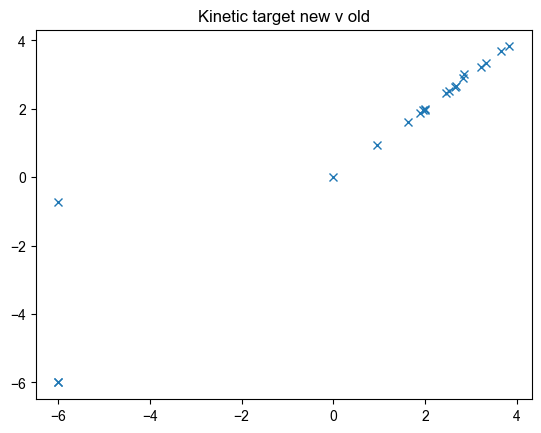

In [23]:
plt.plot(df_kinetic_constrained_new['target'],df_kinetic_constrained_new['target_new'], 'x')
plt.title('Kinetic target new v old')
#### 2.9.1.1-RXN is interesting. Why is the new versus old target so different? 

### Count Substrates

In [38]:
homeostatic_metabolite_counts = counts(
    bulk.iloc[0], self.homeostatic_metabolite_idx
        )

kinetic_enzyme_counts = counts(bulk.iloc[0], self.kinetics_enzymes_idx)
kinetic_substrate_counts = counts(bulk_new.iloc[0], self.kinetics_substrates_idx)

# counts of subtrates and enzymes is exactly the same new and old

#TODO: calculate kinetic constraints

171      True
331      True
333      True
346      True
357      True
         ... 
15530    True
15550    True
15568    True
15575    True
15583    True
Name: 0, Length: 307, dtype: bool

In [26]:
homeostatic_metabolite_counts

34        95819
83       245104
102       63741
121       95819
218      211081
          ...  
11173     69434
11385     69434
7983      69434
1018      69434
11826     69434
Name: 0, Length: 172, dtype: int64